## Continuation of EDA and Evaluating Valuation Set on German Traffic Sign Dataset using EfficientNet and ResNet18
### Billy Ryan

This file is a continuation of the initial eda file, just with an update of validation set to see the increase in accuracy. Everything else is the same but I thought it was worth to see how the project evolved over time so I decided to keep both files separate as a good comparison tool. All of the EDA conducted remains the same obviously, so if need be just scroll through it if you have already read the file from before. Once again, this file was more of a progress check and a slight continuation, nothing major.

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import kagglehub
from typing import List
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import math
from typing import List, Tuple
from collections import Counter
import seaborn as sns

c:\Users\billy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version of the dataset
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

In [3]:
print(os.listdir(path))

train_df_path =  os.path.join(path, "Train.csv")
test_df_path =  os.path.join(path, "Test.csv")

train_img_path =  os.path.join(path, "Train")
test_img_path =  os.path.join(path, "Test")

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']


Much of the following EDA was lifted and/or inspired from Neva's and Gracie's work alongside many kaggle notebooks which have been referenced below, making alterations for ease of use and more thorough analysis. This file will not go into much detail as that has been done separately either in the report folder or in a markdown file in my (Billy) folder.

In [4]:
train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)

In [5]:
train_df['ClassId'].value_counts()

ClassId
2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
35    1200
18    1200
17    1110
14     780
31     780
33     689
15     630
26     600
28     540
23     510
30     450
6      420
16     420
34     420
22     390
36     390
20     360
40     360
21     330
39     300
29     270
24     270
42     240
32     240
27     240
41     240
0      210
19     210
37     210
Name: count, dtype: int64

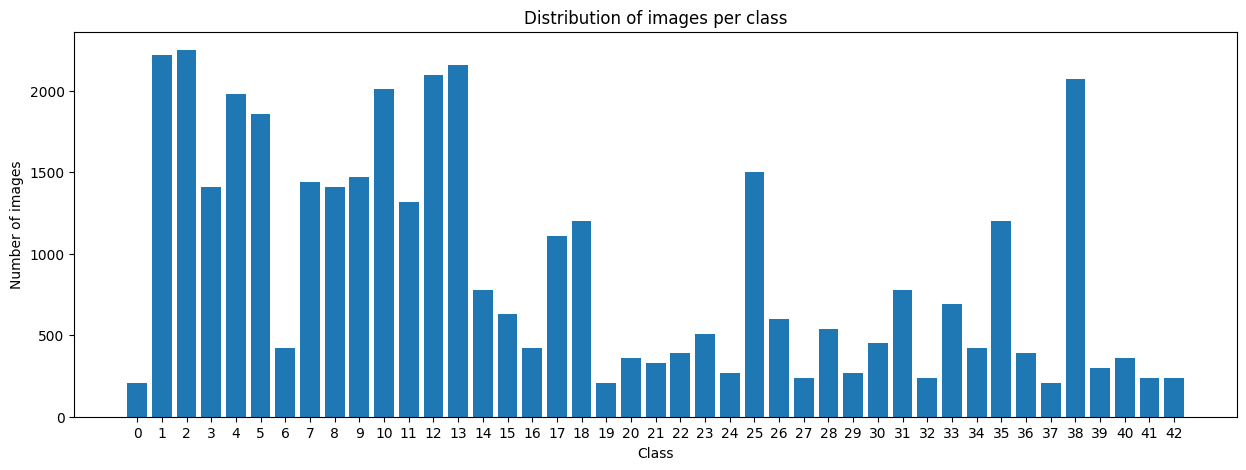

In [6]:
counts = train_df['ClassId'].value_counts().sort_index()

plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("Distribution of images per class")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.xticks(counts.index)
plt.show()

In [7]:
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}

train_df["ClassName"] = train_df['ClassId'].map(class_names)
test_df["ClassName"] = test_df['ClassId'].map(class_names)

In [8]:
print(f"Maximum images per class: {train_df['ClassName'].value_counts().max()} (Class: {train_df['ClassName'].value_counts().idxmax()})")
print(f"Minimum images per class: {train_df['ClassName'].value_counts().min()} (Class: {train_df['ClassName'].value_counts().idxmin()})")
print(f"Average images per class: {train_df['ClassName'].value_counts().mean():.1f}")

Maximum images per class: 2250 (Class: Speed Limit (50Km/hr))
Minimum images per class: 210 (Class: Speed Limit (20Km/hr))
Average images per class: 911.8


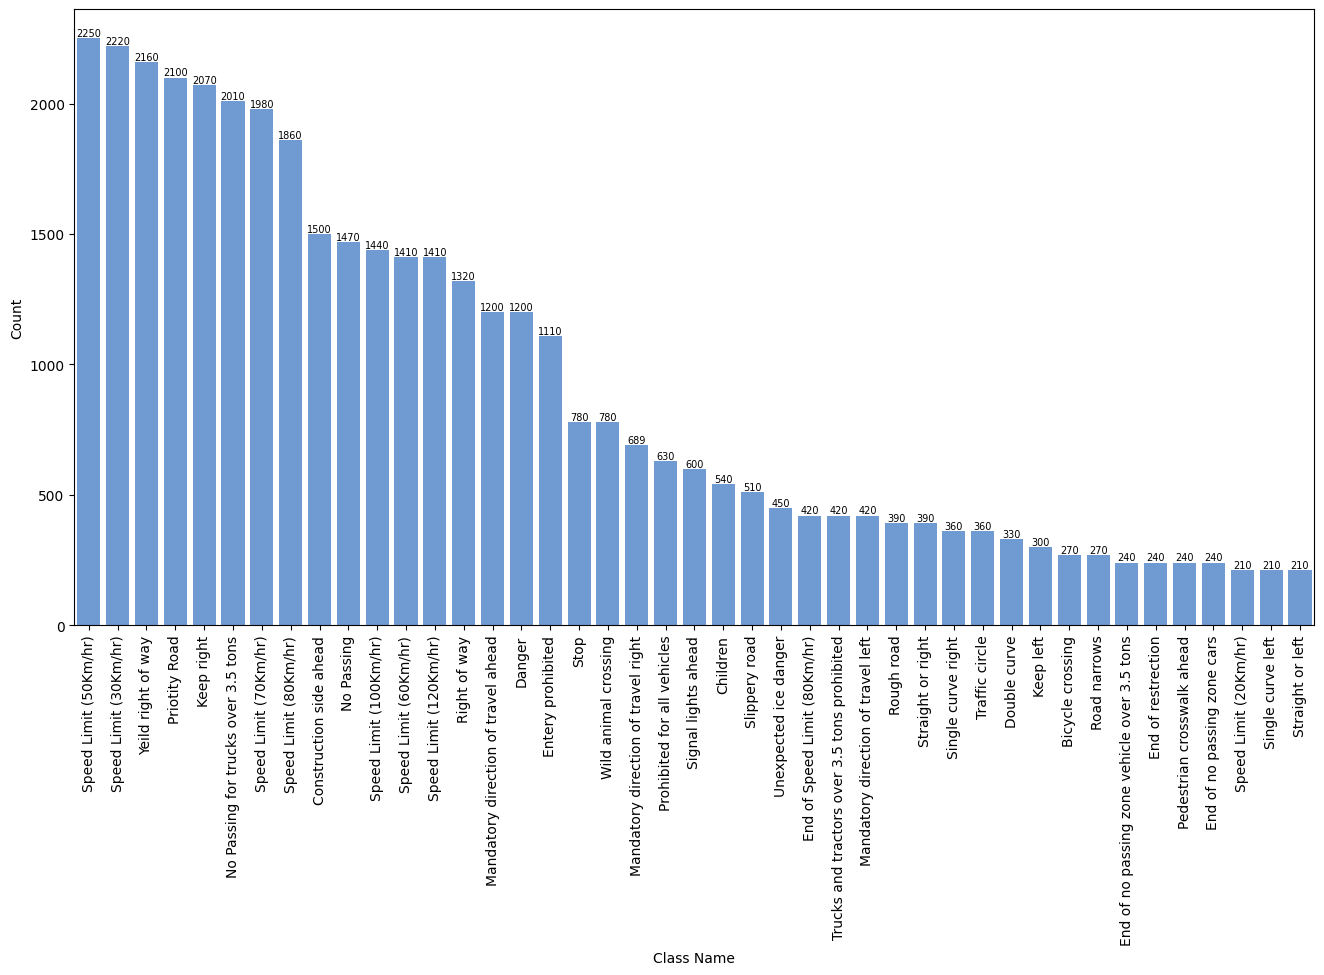

In [9]:
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=train_df, x="ClassName", order=train_df["ClassName"].value_counts().index, color="#5F98E2")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fontsize=7)
plt.show()

In [10]:
def random_image_generator(class_id):
    if class_id < 0 or class_id > 42:
        raise ValueError("class_id must be between 0 and 42 inclusive.")

    folder = os.path.join(train_img_path, str(class_id))
    image_files = [f for f in os.listdir(folder) if not f.startswith(".")]

    filename = random.choice(image_files)
    sample_path = os.path.join(folder, filename)

    img = Image.open(sample_path)

    return img

Now we can randomise images that are in our training dataset. This will help familiarise the user with the types of images we are dealing with.

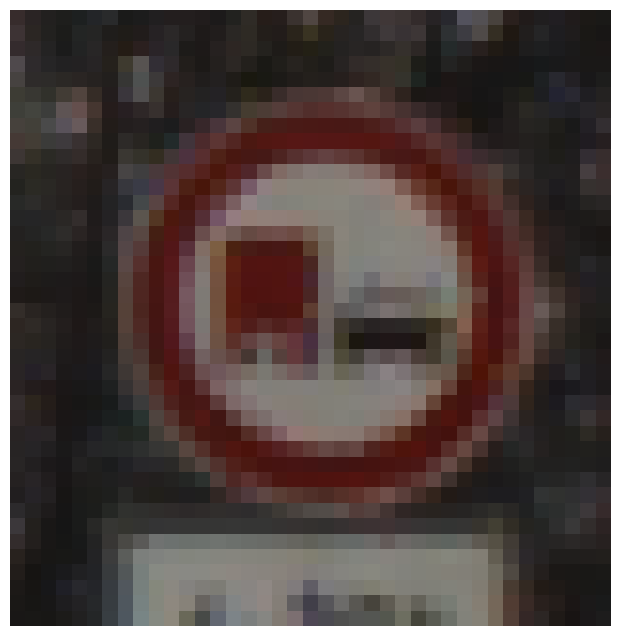

In [11]:
random_class = random.randint(0, 42)
img1 = random_image_generator(random_class)

plt.figure(figsize=(8,8))
plt.imshow(img1)
plt.axis("off")
plt.show()

In [12]:
def get_image_paths(filepath: str) -> Tuple[List[str], List[str]]:
    image_paths = []
    class_labels = []

    for root, _, files in os.walk(filepath):
        for filename in files:
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".ppm", ".bmp")):
                full_path = os.path.join(root, filename)
                image_paths.append(full_path)

                # grab class folder name
                class_id = os.path.basename(root)
                class_labels.append(class_id)

    return image_paths, class_labels

train_image_paths, train_labels = get_image_paths(train_img_path)

In [13]:
def print_sample_images(n, cols):
    total = len(train_image_paths)
    num_images = min(n*cols, total)

    if num_images >= total:
        print("WARNING: Total images exceed available images. Returning all available images. This may take a while.")

    if (n, cols) >= (100, 5):
        print("WARNING: You are attempting to plot many images. This may take a while.")

    plt.figure(figsize=(cols*3, n*3))

    for i, k in enumerate(random.sample(range(total), num_images), start=1):
        img = plt.imread(train_image_paths[k])
        plt.subplot(n, cols, i)
        plt.imshow(img)
        plt.title(class_names[int(train_labels[k])])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

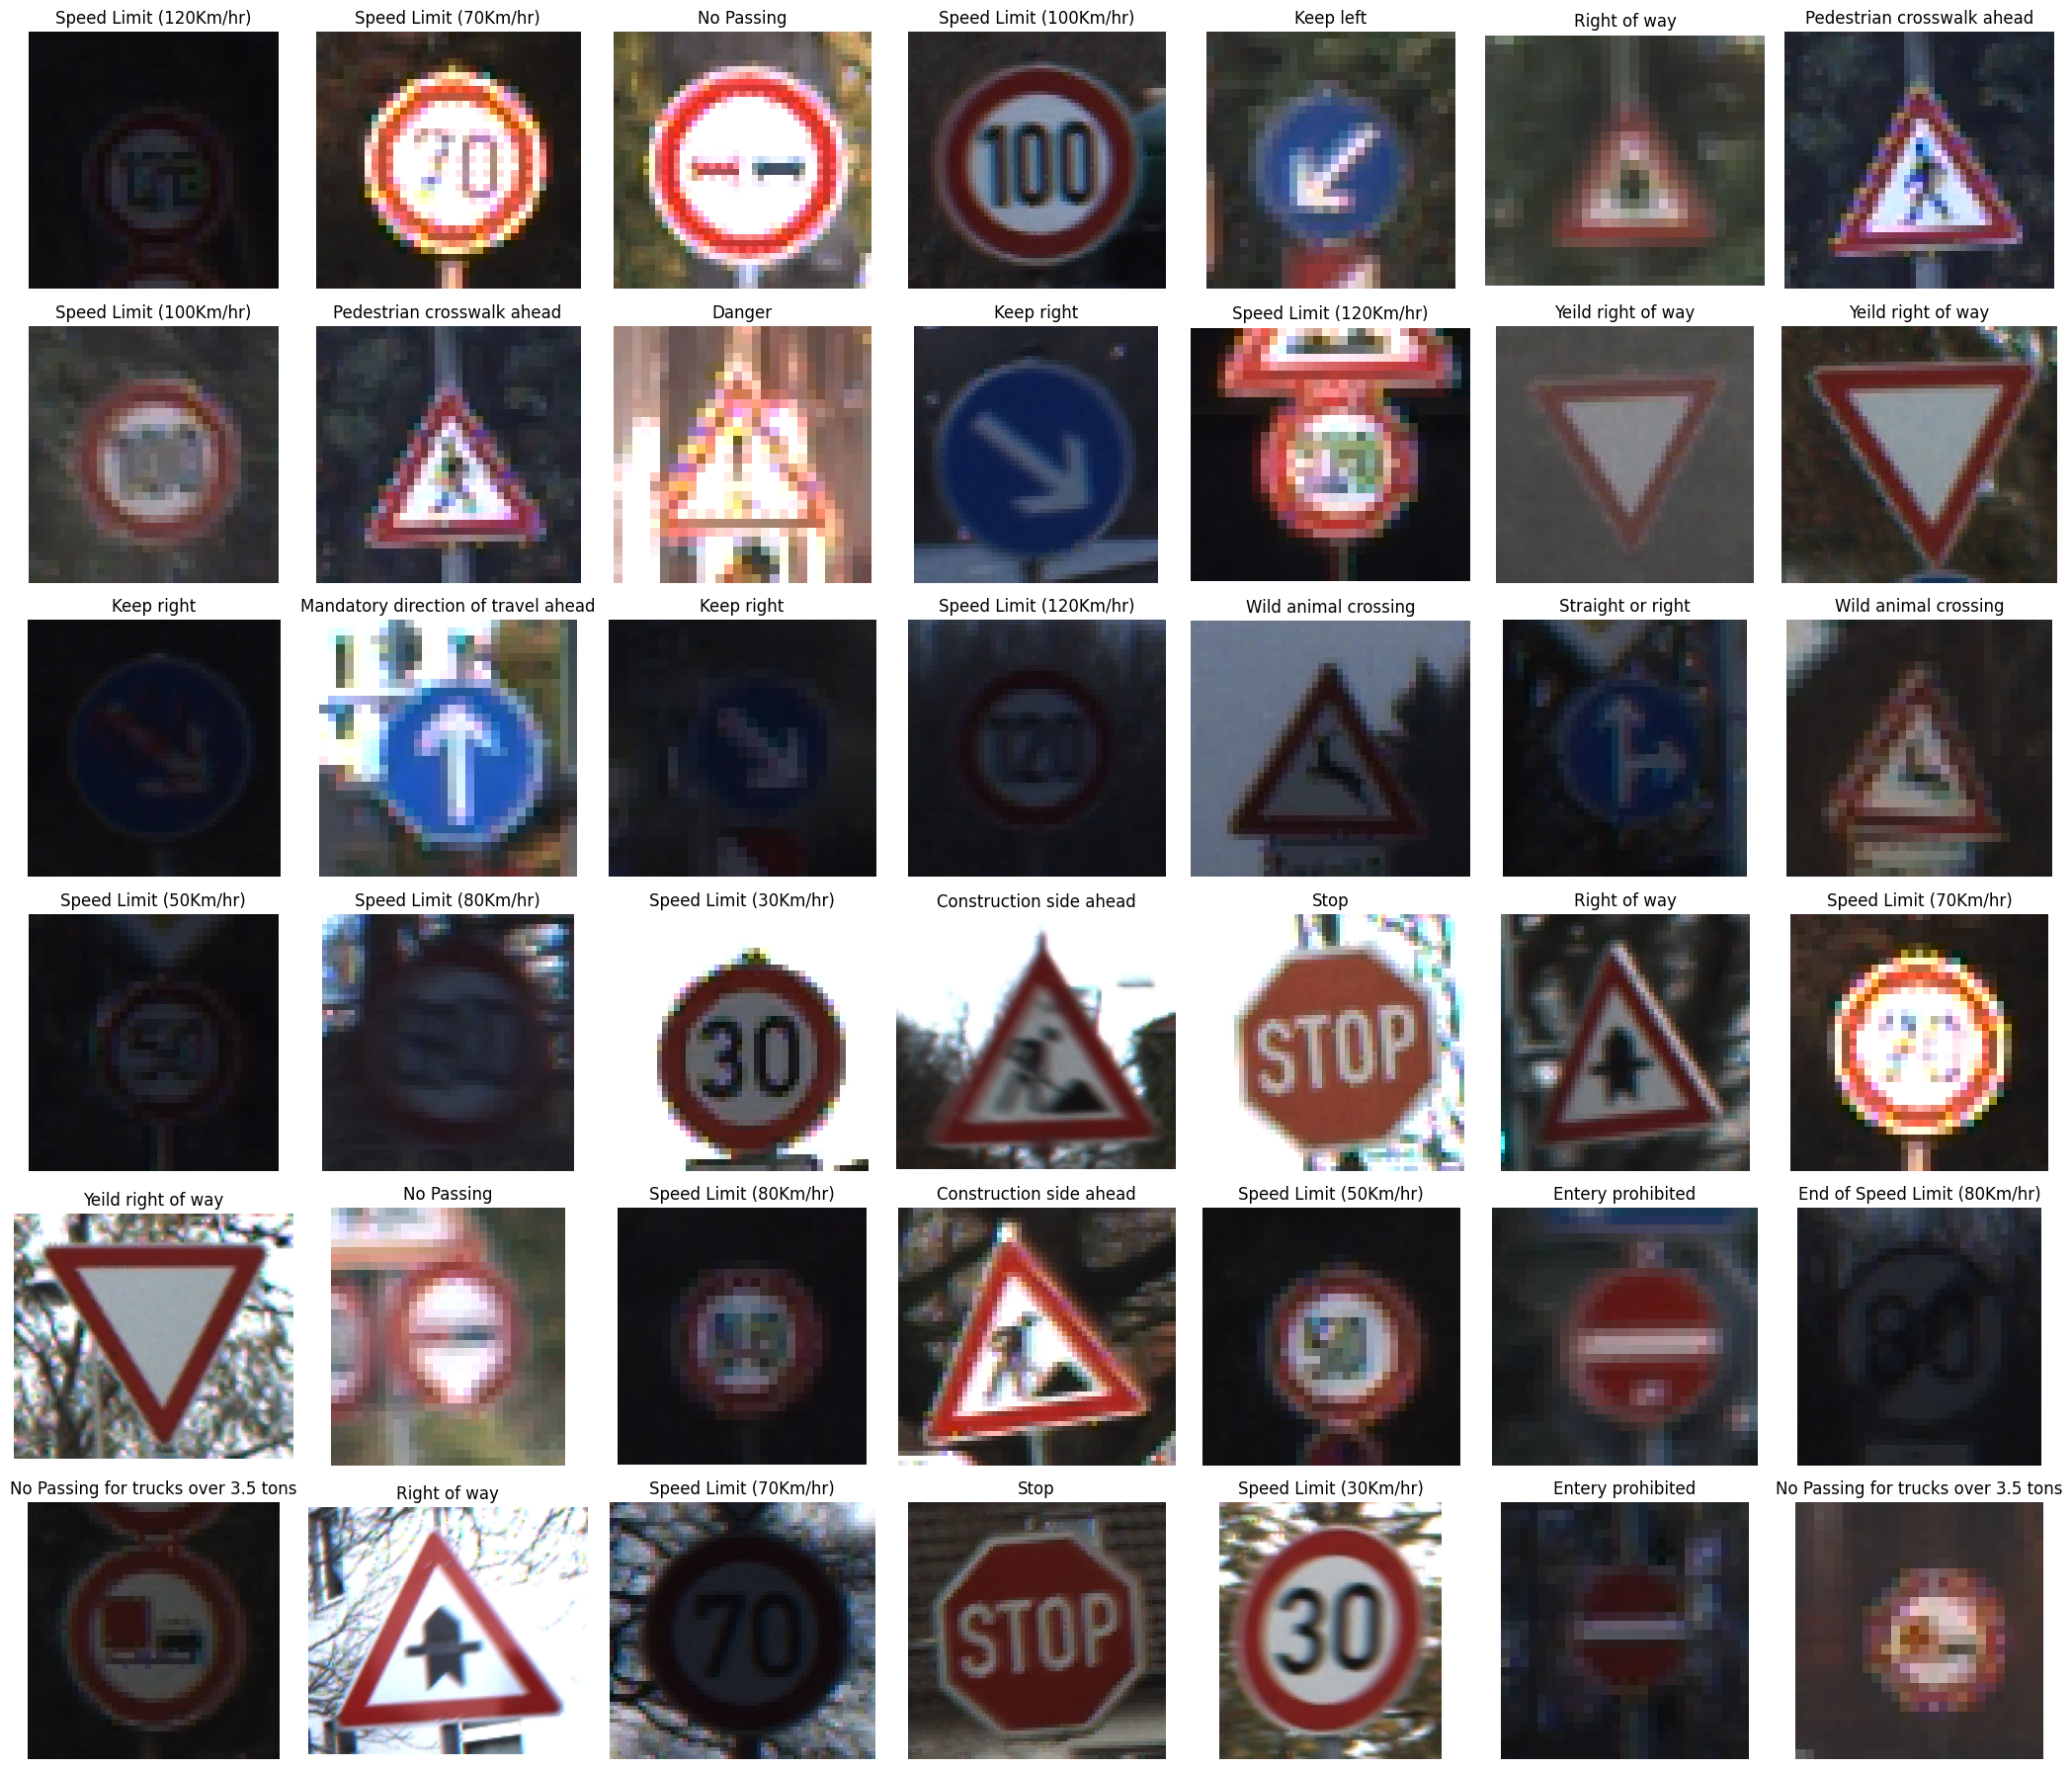

In [14]:
print_sample_images(6,7)

In [15]:
def random_sample_images_per_class():
    for c in sorted(train_df['ClassId'].unique()):
        folder = os.path.join(train_img_path, str(c))
        filenames = os.listdir(folder)
        
        sample_files = random.sample(filenames, min(5, len(filenames)))
        
        # Plot images
        plt.figure(figsize=(15, 3))
        class_name = class_names.get(c, f"Class {c}")
        plt.suptitle(f"{class_name} (Class {c})", fontsize=16)
        
        for i, f in enumerate(sample_files):
            img_path = os.path.join(folder, f)
            img = Image.open(img_path)
            
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.axis("off")
        
        plt.show()

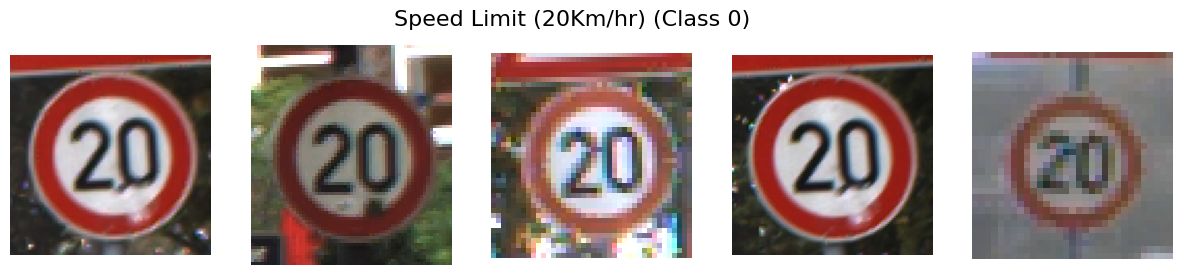

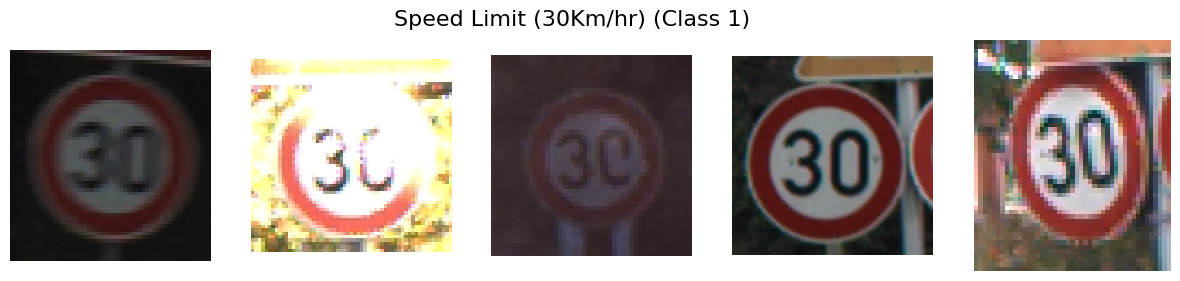

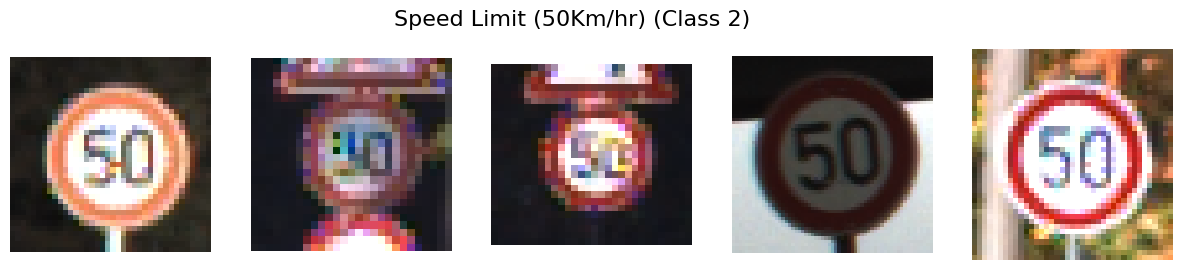

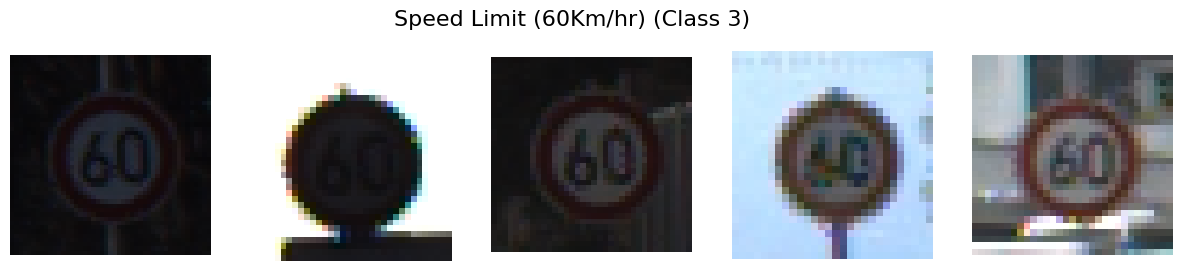

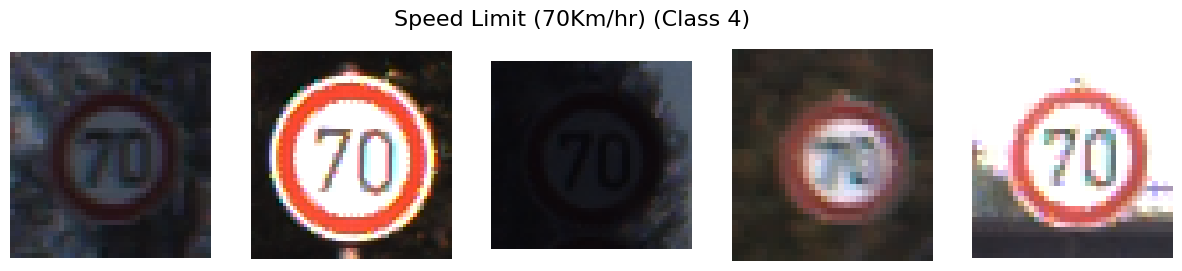

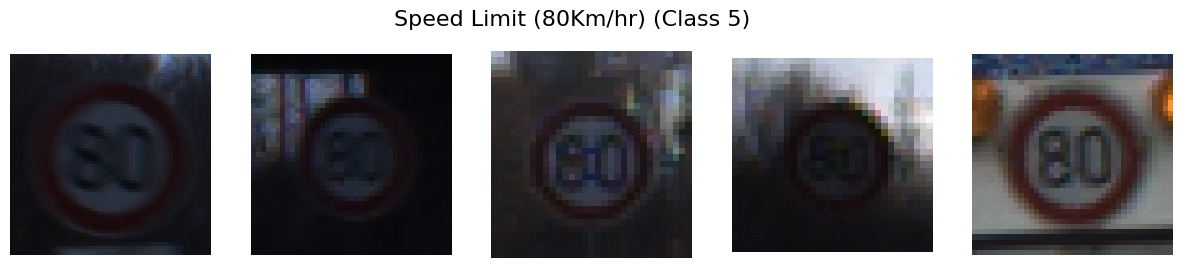

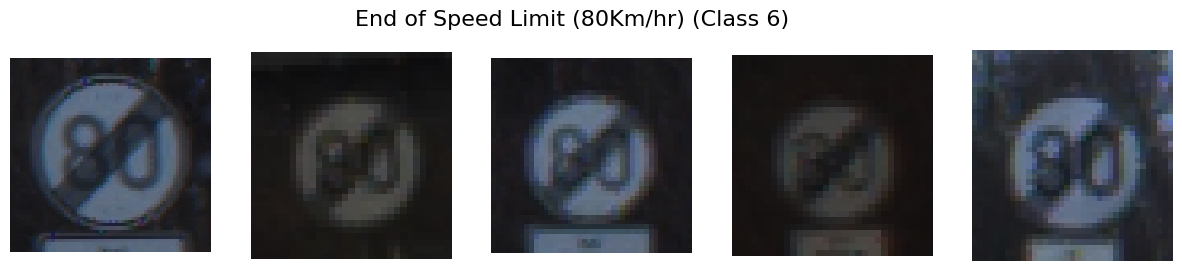

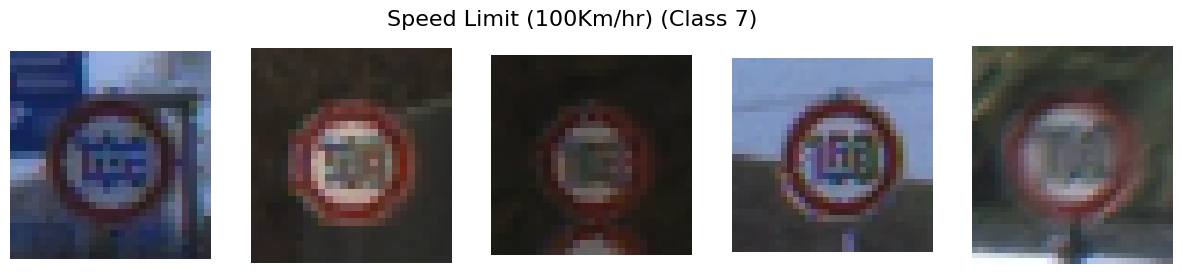

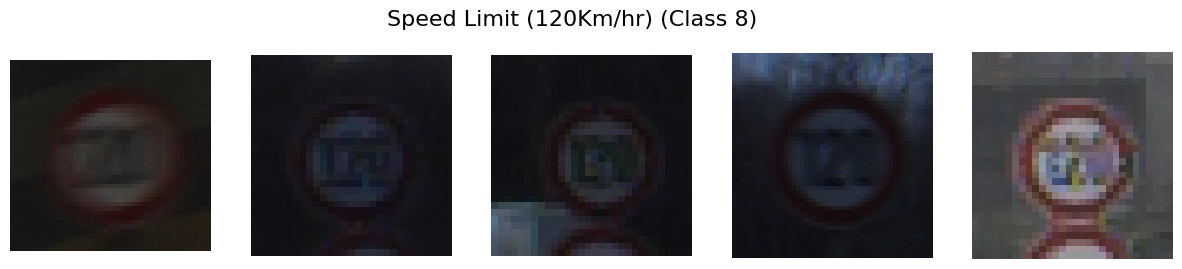

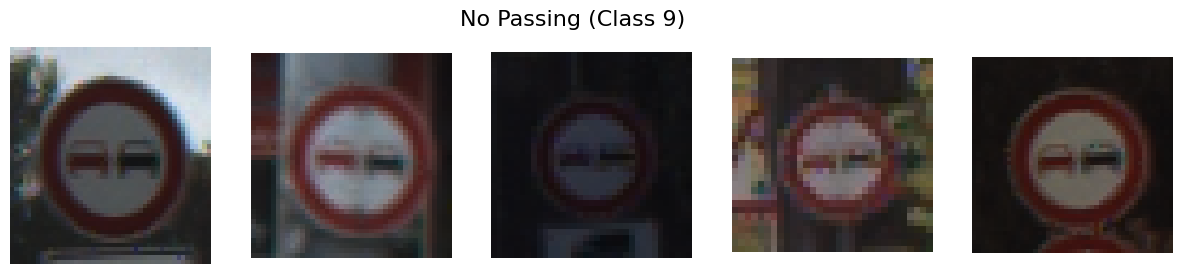

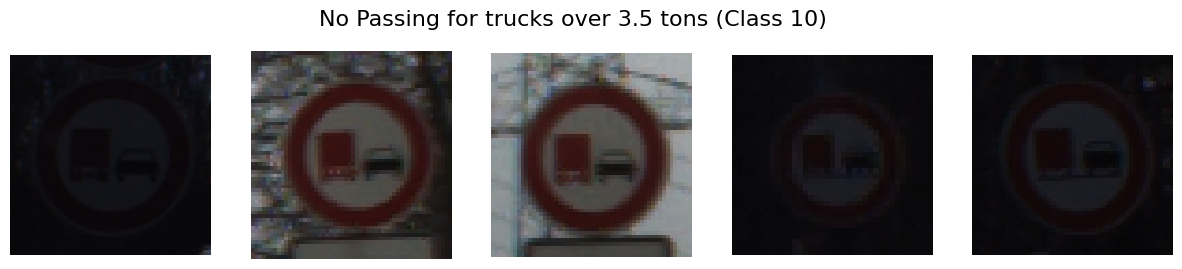

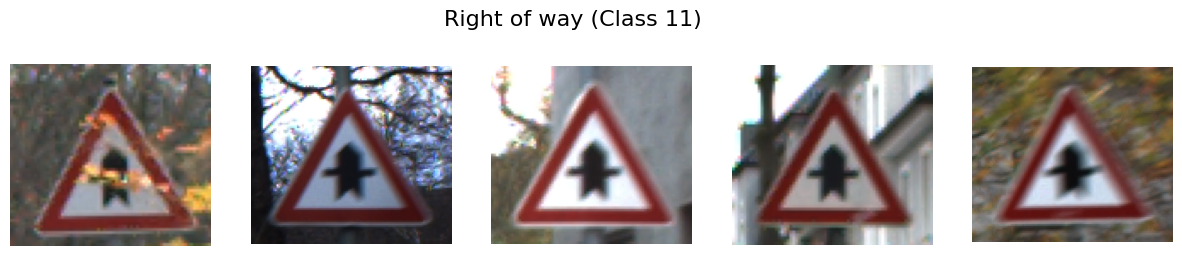

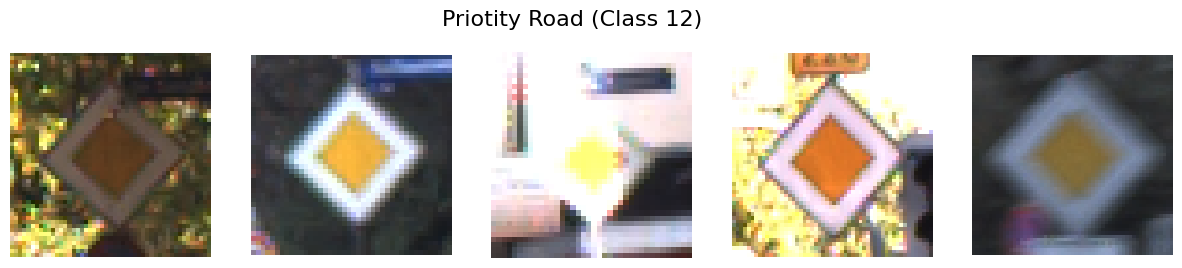

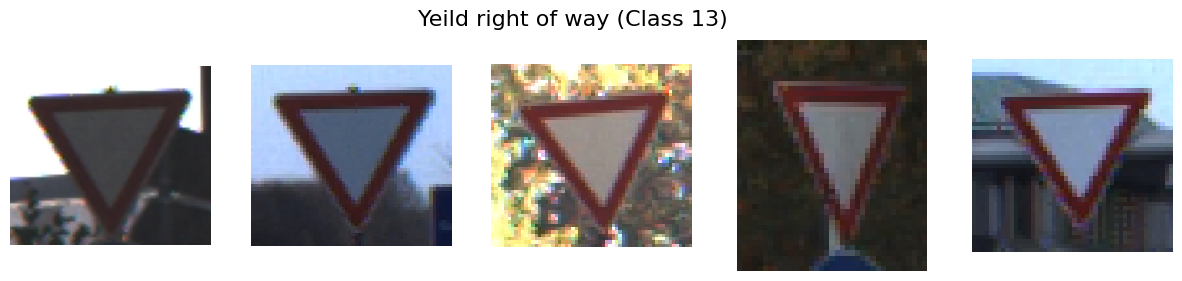

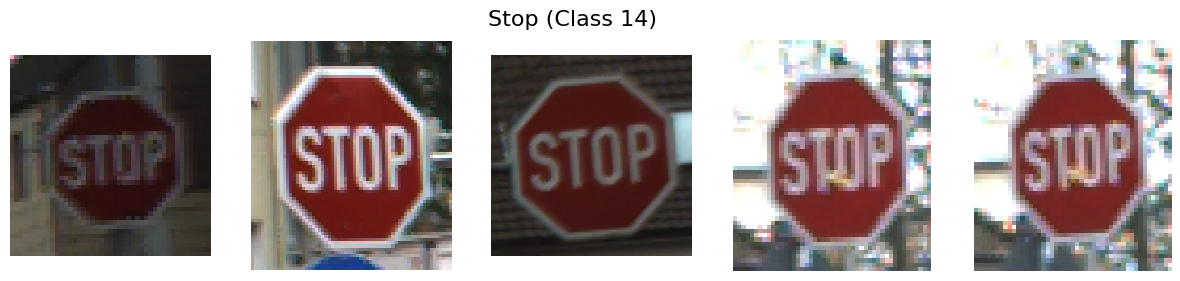

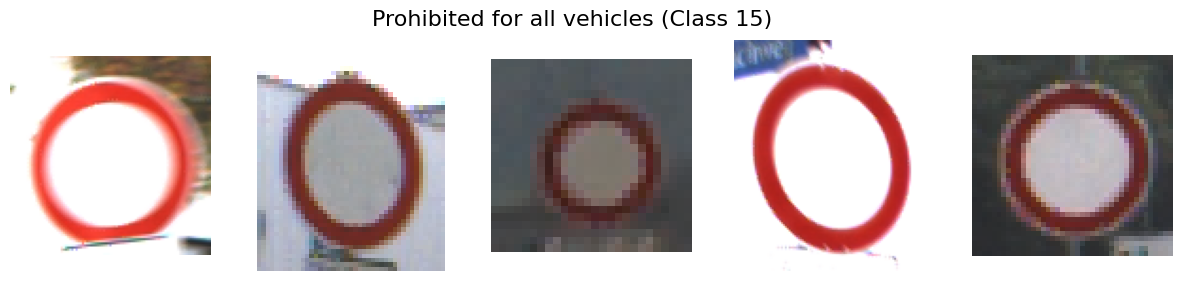

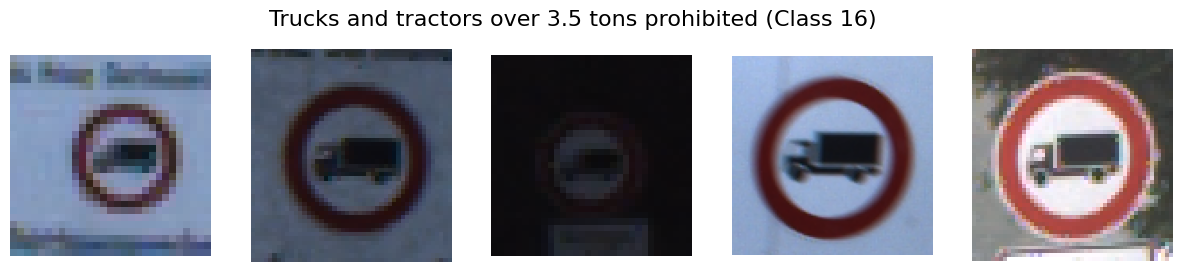

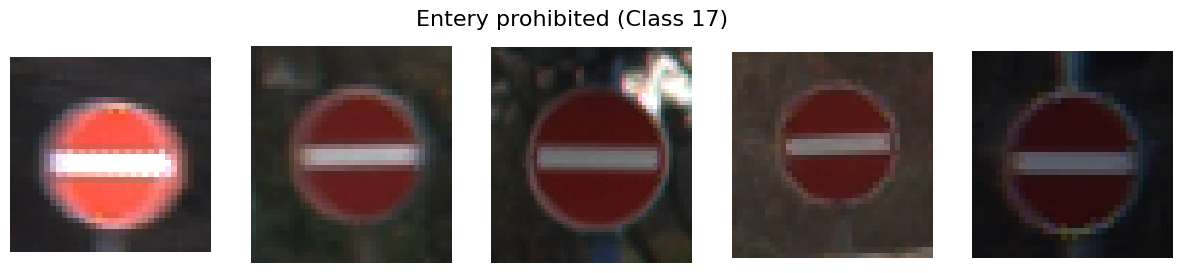

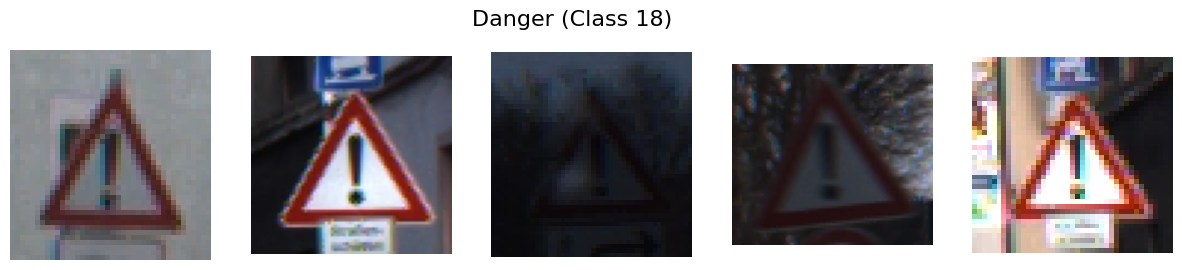

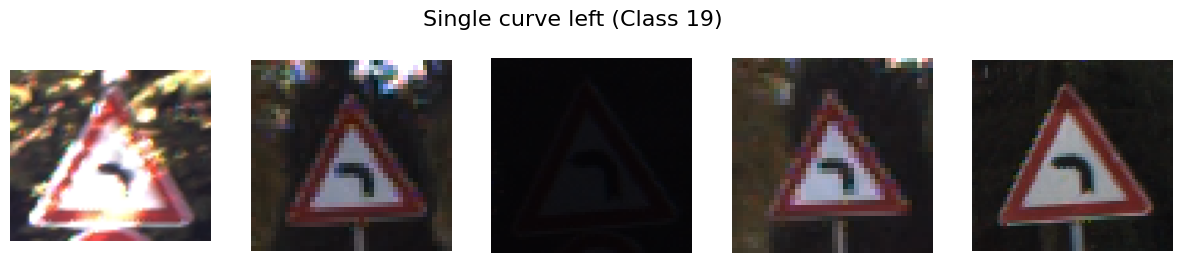

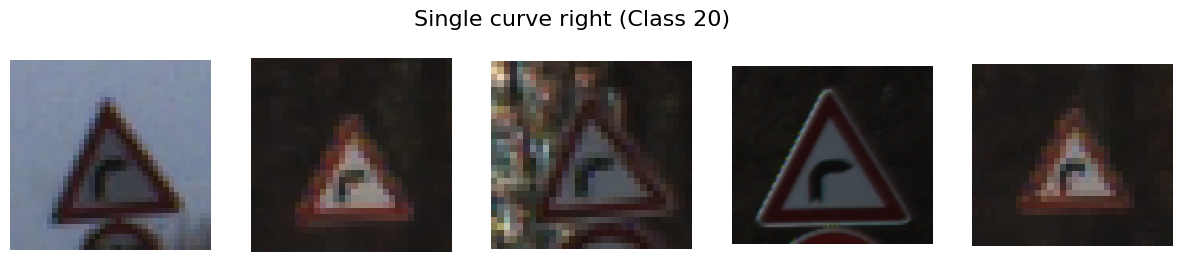

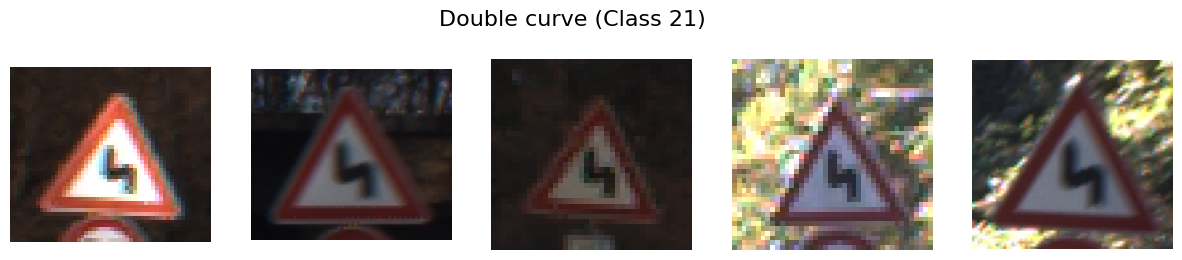

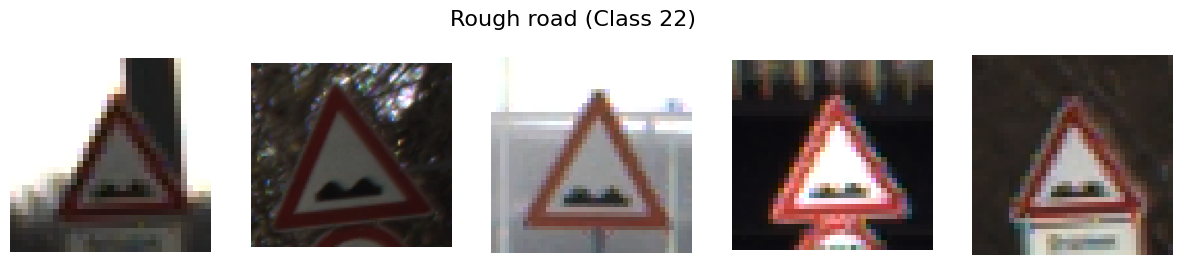

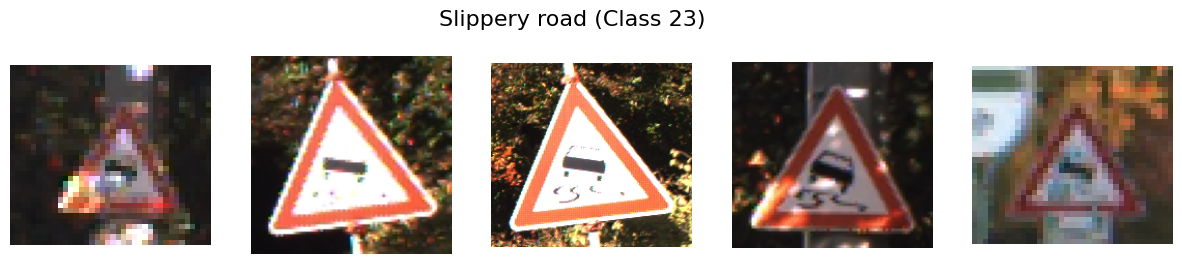

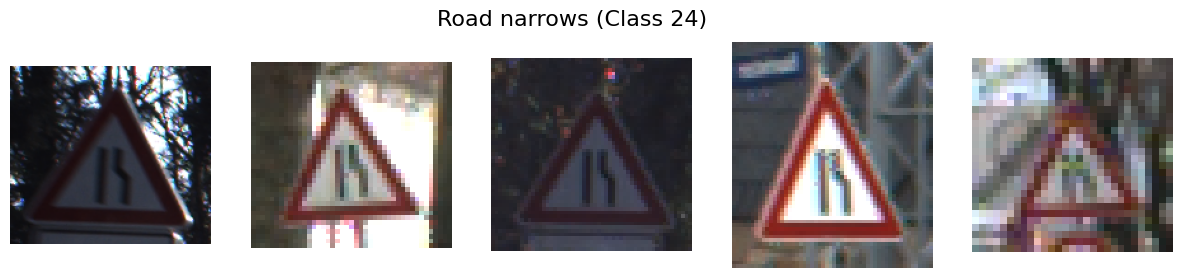

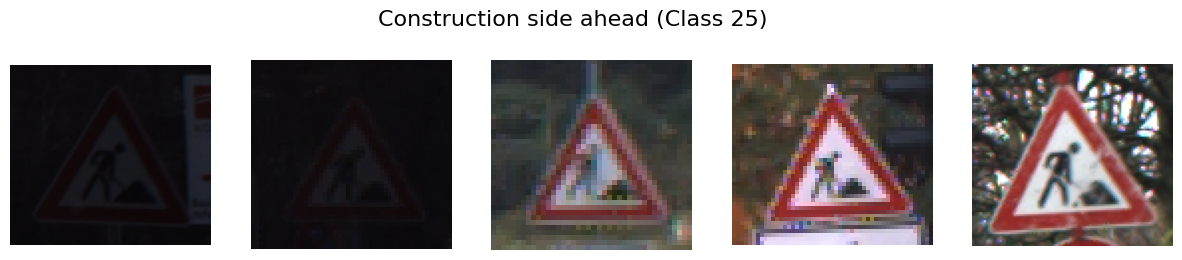

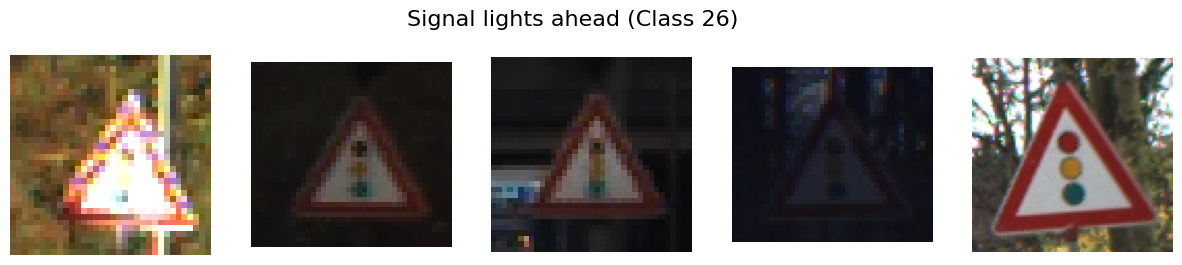

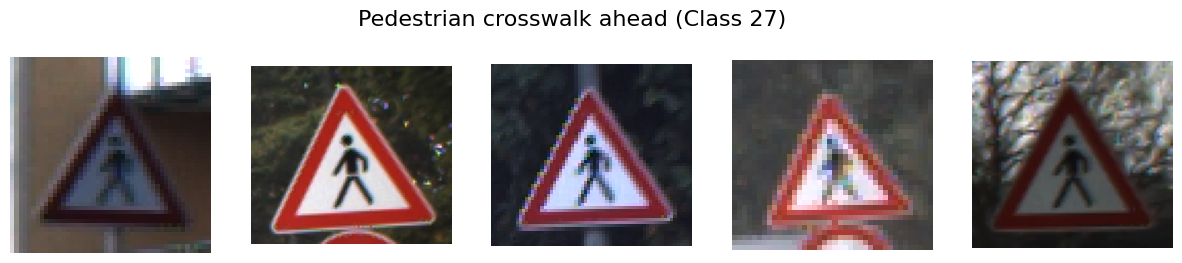

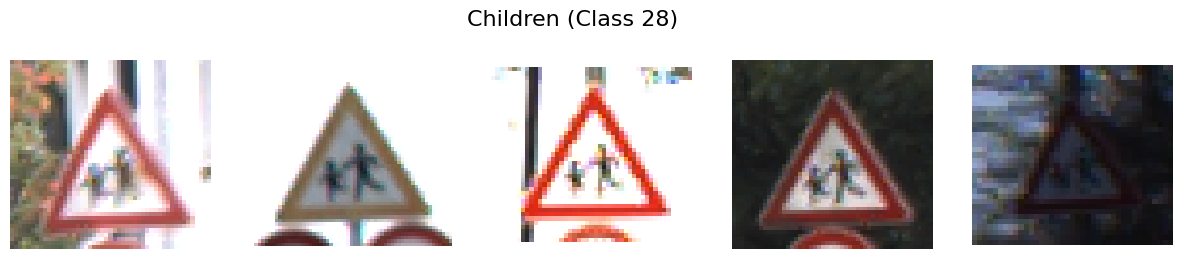

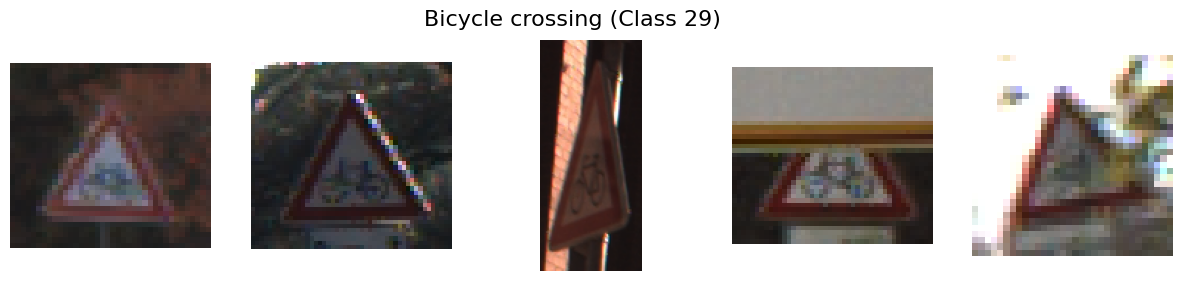

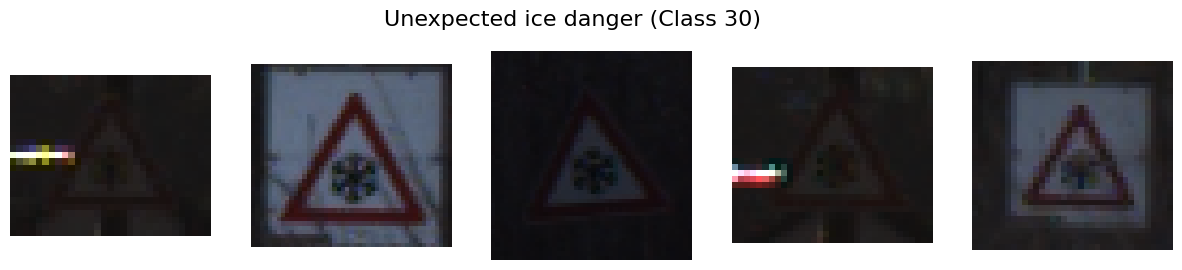

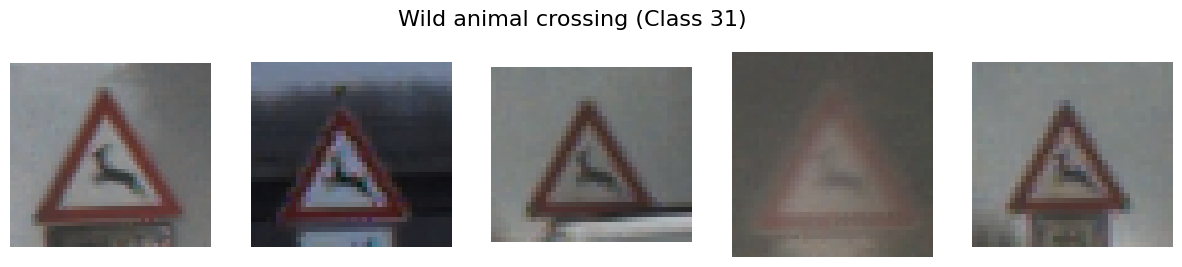

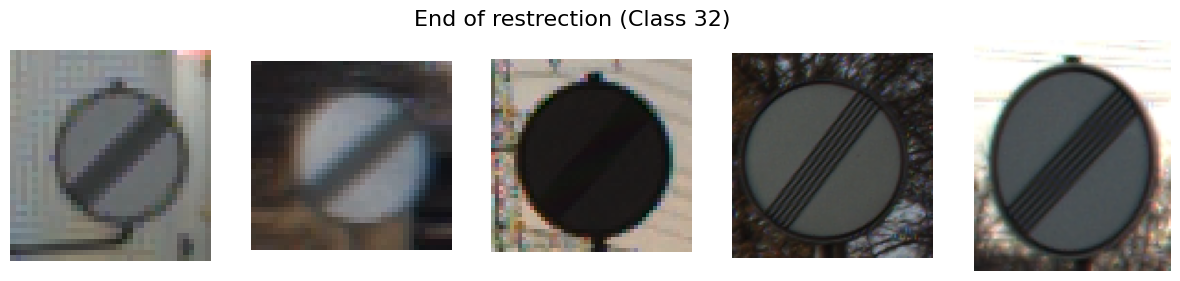

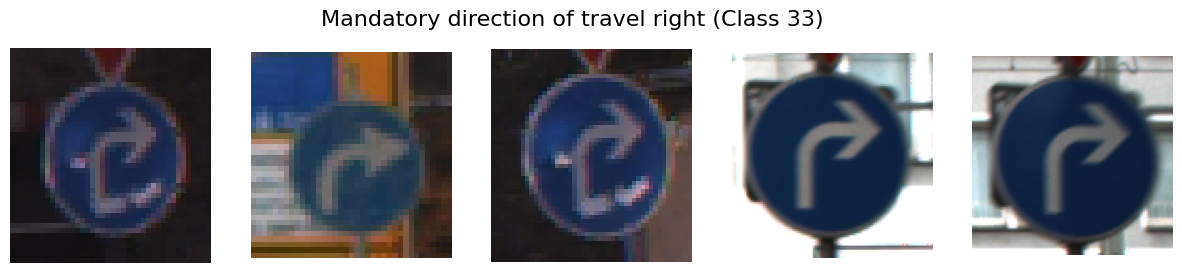

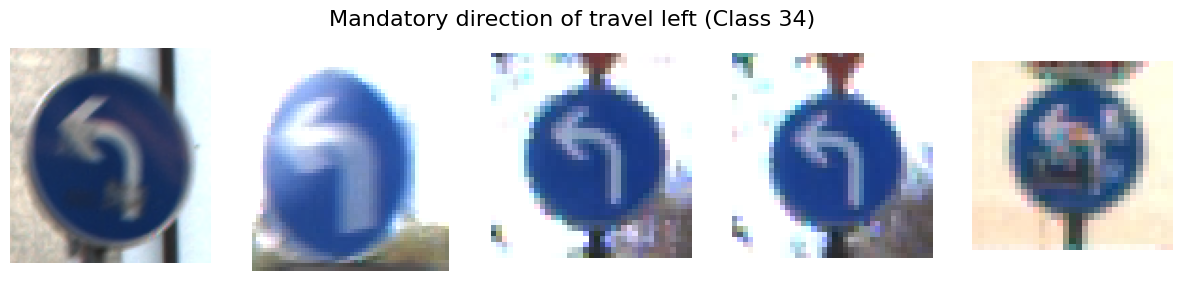

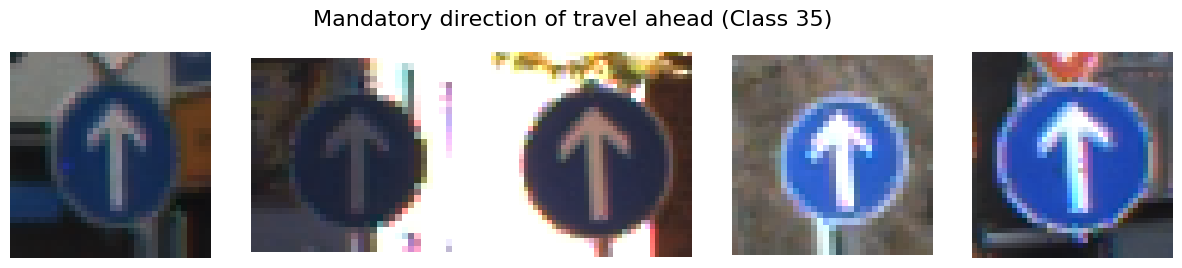

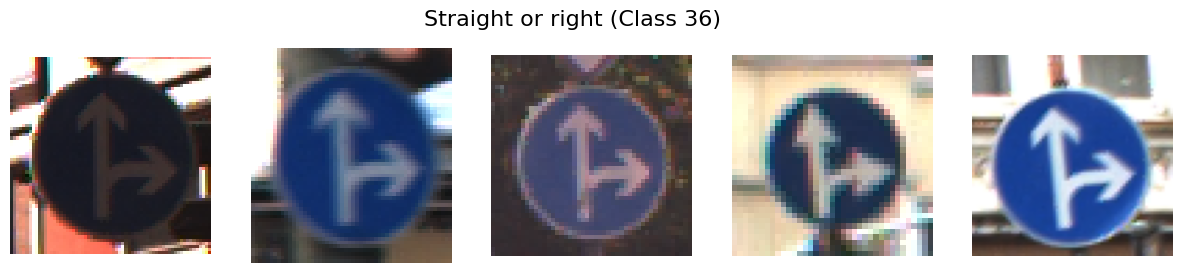

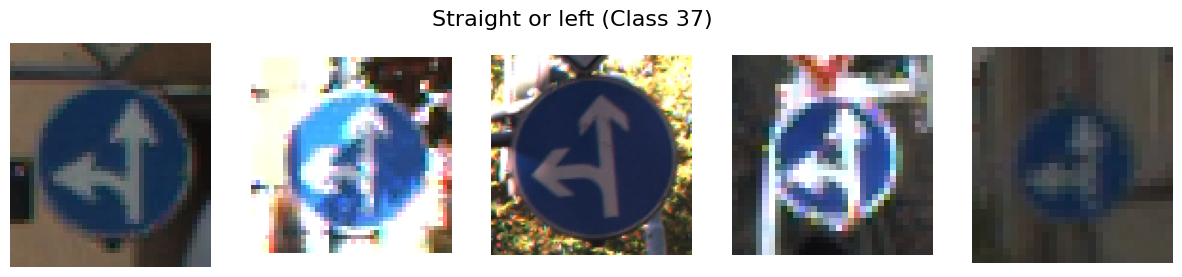

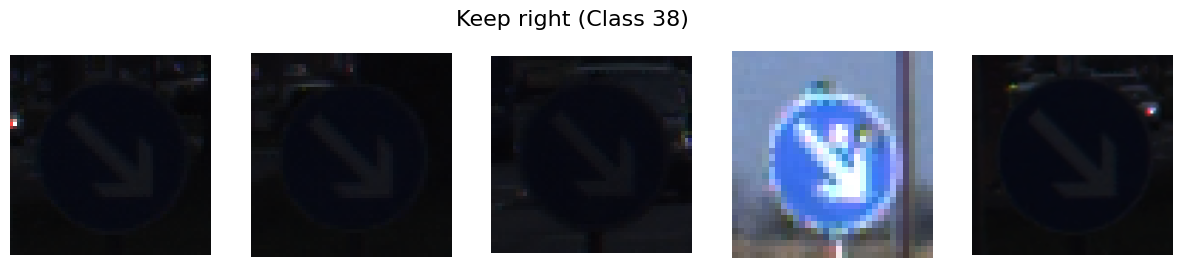

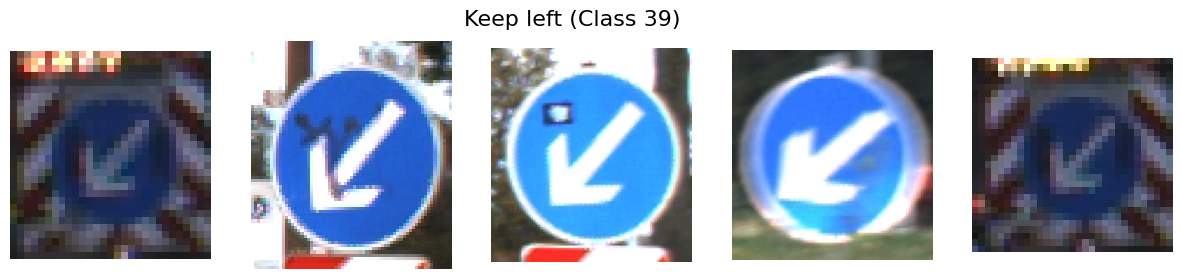

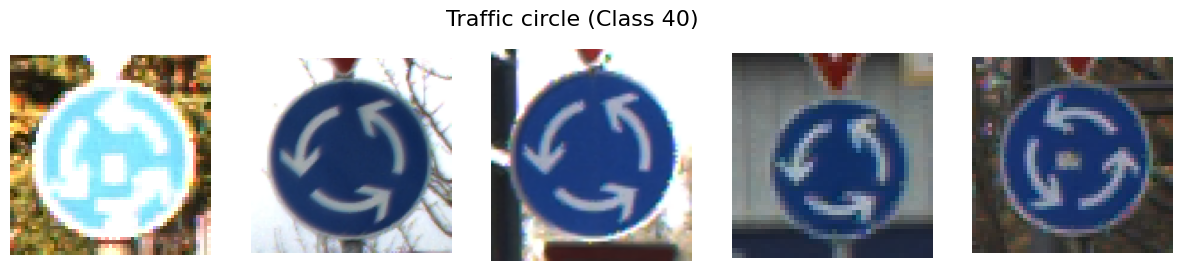

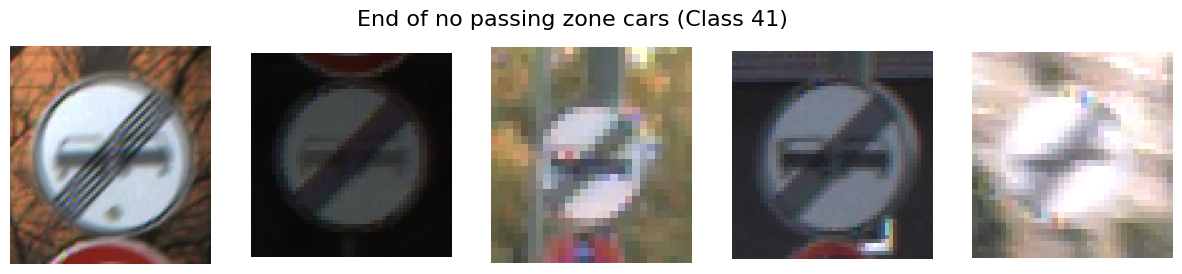

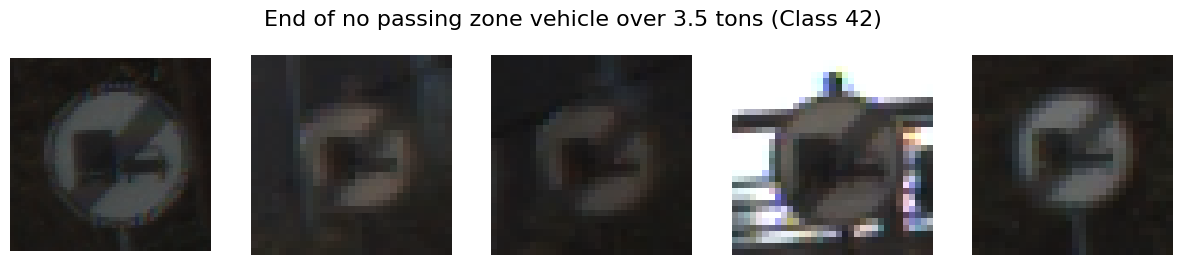

In [16]:
random_sample_images_per_class()

In [17]:
def resolutions(image_paths, max_images=None):
    resolutions = []
    for path in image_paths[:max_images]:
        with Image.open(path) as img:
            resolutions.append(img.size)
    return resolutions

resolutions(train_image_paths, max_images=5000)

[(29, 30),
 (30, 30),
 (30, 30),
 (31, 31),
 (30, 32),
 (31, 31),
 (33, 34),
 (34, 35),
 (33, 34),
 (36, 36),
 (35, 36),
 (37, 38),
 (37, 38),
 (40, 39),
 (41, 42),
 (44, 44),
 (46, 44),
 (47, 48),
 (50, 48),
 (53, 51),
 (57, 54),
 (59, 58),
 (63, 61),
 (70, 70),
 (76, 76),
 (85, 86),
 (97, 97),
 (108, 110),
 (124, 127),
 (144, 148),
 (29, 30),
 (30, 30),
 (30, 29),
 (31, 31),
 (31, 31),
 (32, 32),
 (33, 34),
 (34, 33),
 (33, 33),
 (34, 33),
 (36, 35),
 (35, 36),
 (36, 36),
 (36, 36),
 (37, 36),
 (38, 38),
 (38, 39),
 (39, 41),
 (40, 41),
 (42, 43),
 (43, 43),
 (45, 45),
 (45, 47),
 (47, 48),
 (49, 49),
 (50, 52),
 (53, 54),
 (55, 56),
 (57, 59),
 (59, 61),
 (27, 26),
 (27, 28),
 (27, 28),
 (30, 29),
 (30, 29),
 (31, 31),
 (30, 30),
 (32, 31),
 (31, 32),
 (34, 33),
 (34, 34),
 (35, 35),
 (38, 37),
 (39, 39),
 (40, 39),
 (41, 41),
 (44, 44),
 (46, 45),
 (48, 47),
 (51, 50),
 (52, 52),
 (55, 55),
 (59, 59),
 (62, 63),
 (69, 70),
 (74, 75),
 (83, 85),
 (92, 95),
 (107, 108),
 (122, 124),


In [18]:
def reso_counter(image_paths, max_images=None):
    res_counter = Counter(resolutions(image_paths, max_images))
    print("Top resolutions (Width x Height : Count):")
    for (w, h), count in res_counter.most_common(10):
        print(f"{w} x {h} : {count}")

reso_counter(train_image_paths, max_images=5000)

Top resolutions (Width x Height : Count):
37 x 37 : 62
33 x 34 : 56
31 x 31 : 55
36 x 36 : 55
38 x 38 : 52
35 x 35 : 52
30 x 30 : 50
34 x 34 : 50
34 x 33 : 48
39 x 39 : 47


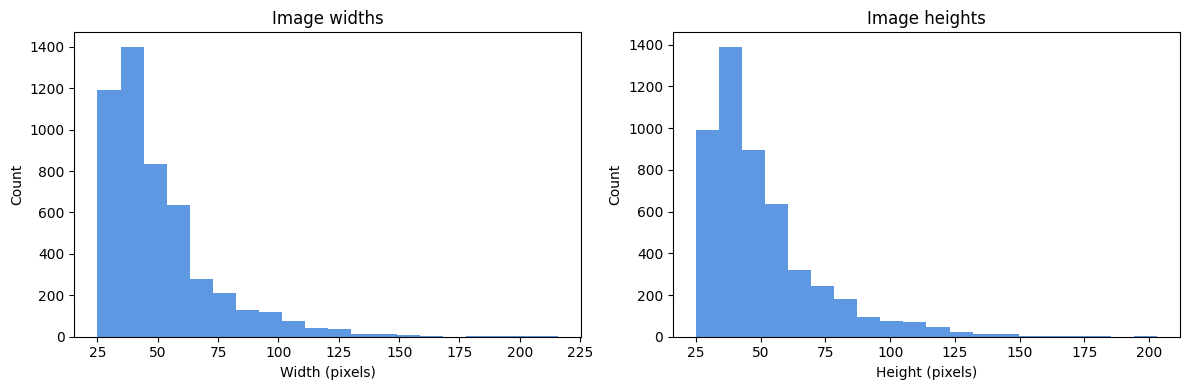

In [19]:
def reso_histogram(image_paths, max_images=None):
    widths, heights = zip(*resolutions(image_paths, max_images))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.hist(widths, bins=20, color="#5F98E2")
    ax1.set(xlabel="Width (pixels)", ylabel="Count", title="Image widths")
    ax2.hist(heights, bins=20, color="#5F98E2")
    ax2.set(xlabel="Height (pixels)", ylabel="Count", title="Image heights")
    plt.tight_layout()
    plt.show()

    return widths, heights

widths, heights = reso_histogram(train_image_paths, max_images=5000)

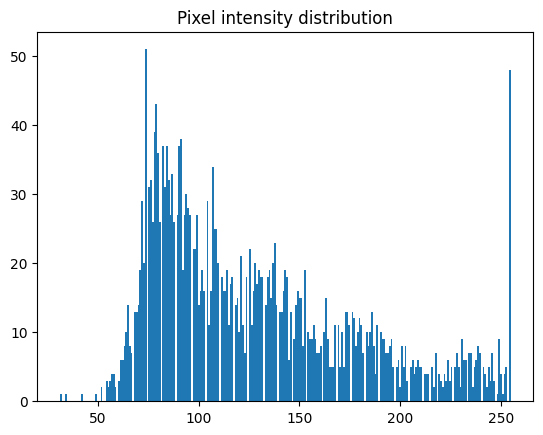

In [20]:
img = np.array(Image.open(train_image_paths[0])) 
plt.hist(img.ravel(), bins=255)
plt.title("Pixel intensity distribution")
plt.show()

In [21]:
def random_pixel_values():
    random.seed(42)
    pixel_values = []

    # take up to 10 random images from each class
    for c in sorted(train_df['ClassId'].unique()):
        folder = os.path.join(train_img_path, str(c))
        filenames = os.listdir(folder)
        sample_files = random.sample(filenames, min(10, len(filenames)))
        
        for f in sample_files:
            img = Image.open(os.path.join(folder, f)).convert('RGB')
            img_array = np.array(img)
            pixel_values.extend(img_array.flatten())

    return pixel_values

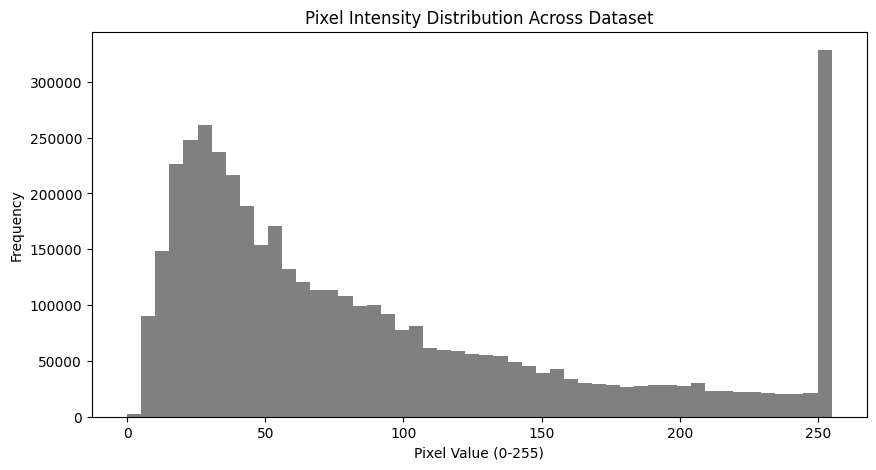

In [22]:
# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(random_pixel_values(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution Across Dataset")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()

In [23]:
pixels = np.array(random_pixel_values())

# Compute more statistics
print("Min pixel value:", np.min(pixels))
print("25th percentile:", np.percentile(pixels, 25))
print("Median (50th percentile):", np.median(pixels))
print("75th percentile:", np.percentile(pixels, 75))
print("Max pixel value:", np.max(pixels))
print("Mean pixel value:", np.mean(pixels))
print("Standard deviation:", np.std(pixels))

Min pixel value: 0
25th percentile: 32.0
Median (50th percentile): 65.0
75th percentile: 128.0
Max pixel value: 255
Mean pixel value: 90.23437089755264
Standard deviation: 73.53056229613492


In [24]:
random.seed(123)
np.random.seed(123)

def augment_image(img):
    # Rotation ±10°
    angle = random.uniform(-10, 10)
    img = img.rotate(angle)

    # Random horizontal and vertical shift (10% max)
    max_shift_x = int(0.1 * img.width)
    max_shift_y = int(0.1 * img.height)
    shift_x = random.randint(-max_shift_x, max_shift_x)
    shift_y = random.randint(-max_shift_y, max_shift_y)
    img = img.transform(img.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

    # Random zoom/crop ±10%
    zoom_factor = random.uniform(0.9, 1.1)
    w, h = img.size
    new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
    img = img.resize((new_w, new_h), Image.BILINEAR)
    img = img.crop((0, 0, w, h))  # crop or pad back to original size

    # Brightness adjustment ±20%
    enhancer = ImageEnhance.Brightness(img)
    factor = random.uniform(0.8, 1.2)
    img = enhancer.enhance(factor)

    return img

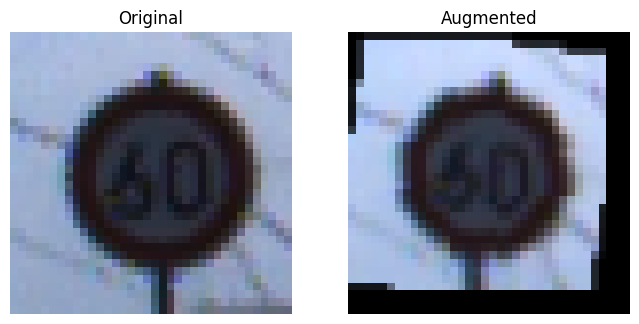

In [25]:
image_number = random.randint(0, 42)

img1 = random_image_generator(image_number)

aug_img1 = augment_image(img1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(aug_img1)
plt.title("Augmented")
plt.axis("off")
plt.show()

In [26]:
classes = sorted(os.listdir(train_img_path))
print("Number of classes:", len(classes))

image_count = {}
half_dataset = []  # final list of selected images

for c in classes:
    folder = os.path.join(train_img_path, c)
    files = os.listdir(folder)

    # count images like your EDA
    image_count[c] = len(files)

    # take 50% of the images in this class
    half = len(files) // 2
    selected = np.random.choice(files, half, replace=False)

    # store full paths
    for f in selected:
        half_dataset.append(os.path.join(folder, f))

print("Original total images:", sum(image_count.values()))
print("Reduced total images:", len(half_dataset))

Number of classes: 43
Original total images: 39209
Reduced total images: 19604


In [27]:
from PIL import Image
from torch.utils.data import Dataset

class FilepathDataset(Dataset):
    def __init__(self, filepaths, transform=None):
        self.filepaths = filepaths
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        path = self.filepaths[idx]
        img = Image.open(path).convert("RGB")

        # label = folder name → class index
        label = int(os.path.basename(os.path.dirname(path)))

        if self.transform:
            img = self.transform(img)
        else:
            from torchvision import transforms
            img = transforms.ToTensor()(img)

        return img, label


In [28]:
import torch
from torchvision import transforms
from torchvision.models import EfficientNet_B0_Weights
IMG_SIZE = 224
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

#train transform and this includes Nevas EDA findings 

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # resize all images to 224×224
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2), 
    transforms.ToTensor(),           # convert PIL image -> tensor
    transforms.Normalize(imagenet_mean, imagenet_std)
])

#validation test transform (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [29]:
SEED = 123
full_ds = FilepathDataset(half_dataset)

train_size = int(0.8 * len(half_dataset))
val_size = len(full_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(
    full_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)
train_ds.dataset.transform = train_transforms
val_ds.dataset.transform = val_transforms

In [30]:
from torch.utils.data import DataLoader 
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

See that train dataset has been reduced to 80% of inital length, as we apportioned the remaining 20% to validation set.

Will follow up with evaluation, importing Neva and Gracie's Models

In [31]:
os.getcwd()
os.chdir("C:/Users/billy/DataScienceToolbox-Project2")
print(os.listdir())

['.DS_Store', '.git', 'Adlan', 'Billy', 'Gracie', 'Leo', 'my_notebook.ipynb', 'Neva', 'README.md', 'Report']


In [32]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

NUM_CLASSES = 43

# Load EfficientNet base model
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
base_model = efficientnet_b0(weights=weights)

# Remove classifier → keep global avg pooling only
base_model.classifier = nn.Identity()

# Freeze base model
for param in base_model.parameters():
    param.requires_grad = False

# Build the same custom head Neva used
model = nn.Sequential(
    base_model,                # (0)
    nn.Linear(1280, 256),      # (2)
    nn.ReLU(),                 # (3)
    nn.Dropout(0.4),           # (4)
    nn.Linear(256, NUM_CLASSES),  # (5)
    nn.Softmax(dim=1)          # (6)
)

# Load the saved weights
state_dict = torch.load("Neva/efficientnet_best.pth", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

Sequential(
  (0): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

In [33]:
from torchvision.models import ResNet50_Weights
from torchvision import models

model_resnet18 = models.resnet18(weights=None)
model_resnet18.fc = torch.nn.Linear(512, 43)   # example for 43 traffic signs
state_dict_resnet18 = torch.load("Gracie/resnet18_traffic_signs.pth", map_location="cpu")
model_resnet18.load_state_dict(state_dict_resnet18)
model_resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

below is validation test.

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model_resnet18.to(device)

correct = 0
correct_resnet18 = 0
total = 0

criterion = nn.CrossEntropyLoss()  # only if you want loss

model.eval()
model_resnet18.eval()
with torch.no_grad():  # disables gradient calculation
    for images, labels in val_loader:   # your validation DataLoader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        outputs_resnet18 = model_resnet18(images)
        _, predicted_resnet18 = torch.max(outputs_resnet18, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_resnet18 += (predicted_resnet18 == labels).sum().item()

accuracy = 100 * correct / total
accuracy_resnet18 = 100 * correct_resnet18 / total
print(f"Validation Accuracy for Efficient Net: {accuracy:.2f}%")
print(f"Validation Accuracy for ResNet18: {accuracy_resnet18:.2f}%")

Validation Accuracy for Efficient Net: 93.39%
Validation Accuracy for ResNet18: 77.51%


In [35]:
class_names = [class_names[i] for i in range(NUM_CLASSES)]

In [36]:
from sklearn.metrics import classification_report

def classification_report_model(model, val_loader, device):
    model.to(device)    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    report = classification_report(all_labels, all_preds, zero_division=0)
    print(report)
    return all_labels, all_preds

In [37]:
from sklearn.metrics import confusion_matrix
true_effnet, pred_effnet = classification_report_model(model, val_loader, device)
cm = confusion_matrix(true_effnet, pred_effnet)

              precision    recall  f1-score   support

           0       1.00      0.76      0.87        17
           1       0.94      0.87      0.91       214
           2       0.84      0.93      0.88       216
           3       0.85      0.92      0.88       145
           4       0.85      0.88      0.86       199
           5       0.89      0.92      0.91       191
           6       0.98      1.00      0.99        41
           7       0.97      0.90      0.93       135
           8       0.92      0.88      0.90       144
           9       0.97      0.94      0.96       151
          10       0.98      0.96      0.97       191
          11       0.90      0.94      0.92       129
          12       1.00      0.99      1.00       213
          13       0.92      1.00      0.96       230
          14       1.00      0.99      0.99        91
          15       1.00      1.00      1.00        56
          16       1.00      1.00      1.00        42
          17       1.00    

In [38]:
true_resnet, pred_resnet = classification_report_model(model_resnet18, val_loader, device)
cm_resnet = confusion_matrix(true_resnet, pred_resnet)

              precision    recall  f1-score   support

           0       0.85      0.65      0.73        17
           1       0.67      0.64      0.65       214
           2       0.50      0.73      0.60       216
           3       0.56      0.70      0.62       145
           4       0.75      0.66      0.71       199
           5       0.71      0.63      0.67       191
           6       1.00      0.90      0.95        41
           7       0.81      0.76      0.78       135
           8       0.79      0.64      0.71       144
           9       0.75      0.79      0.77       151
          10       0.83      0.82      0.82       191
          11       0.84      0.77      0.80       129
          12       0.94      0.97      0.95       213
          13       0.98      0.83      0.90       230
          14       1.00      0.91      0.95        91
          15       0.98      1.00      0.99        56
          16       0.92      0.79      0.85        42
          17       0.90    

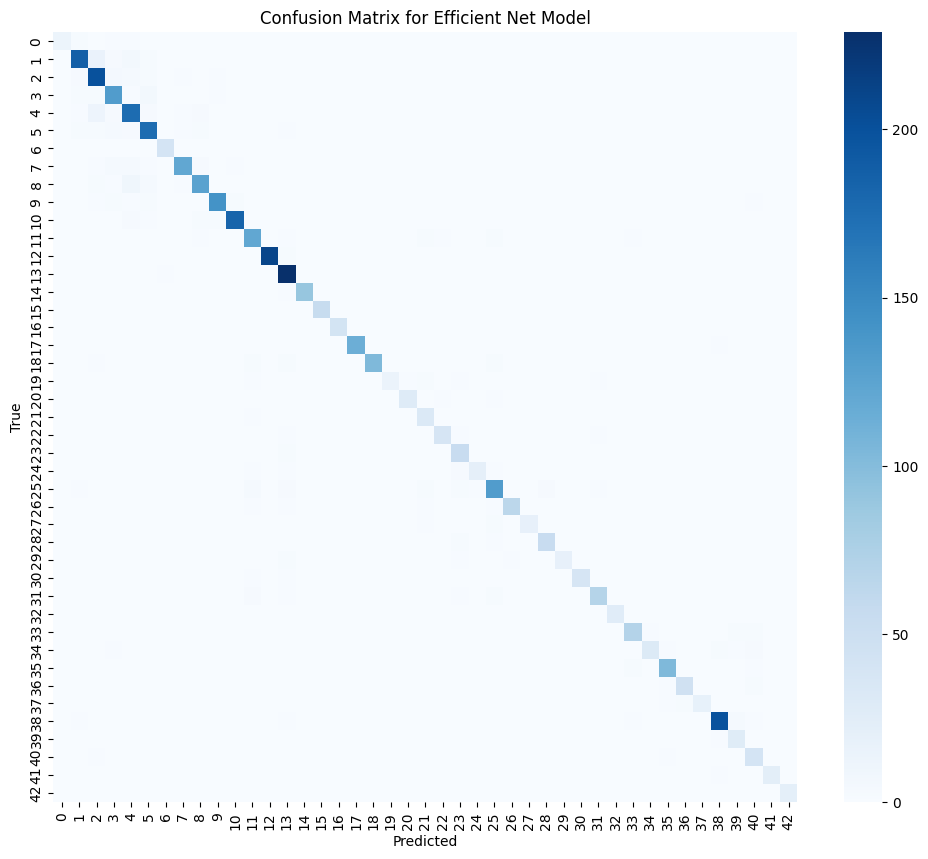

In [39]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Efficient Net Model")
plt.show()

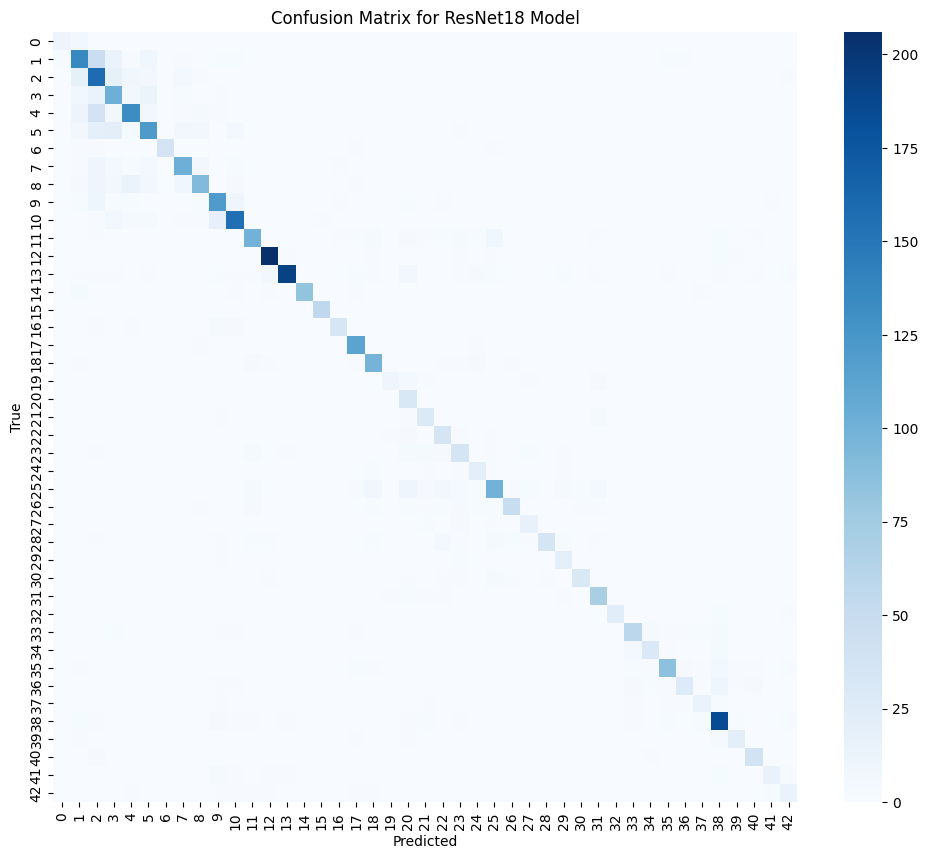

In [40]:
plt.figure(figsize=(12,10))
sns.heatmap(cm_resnet, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for ResNet18 Model")
plt.show()

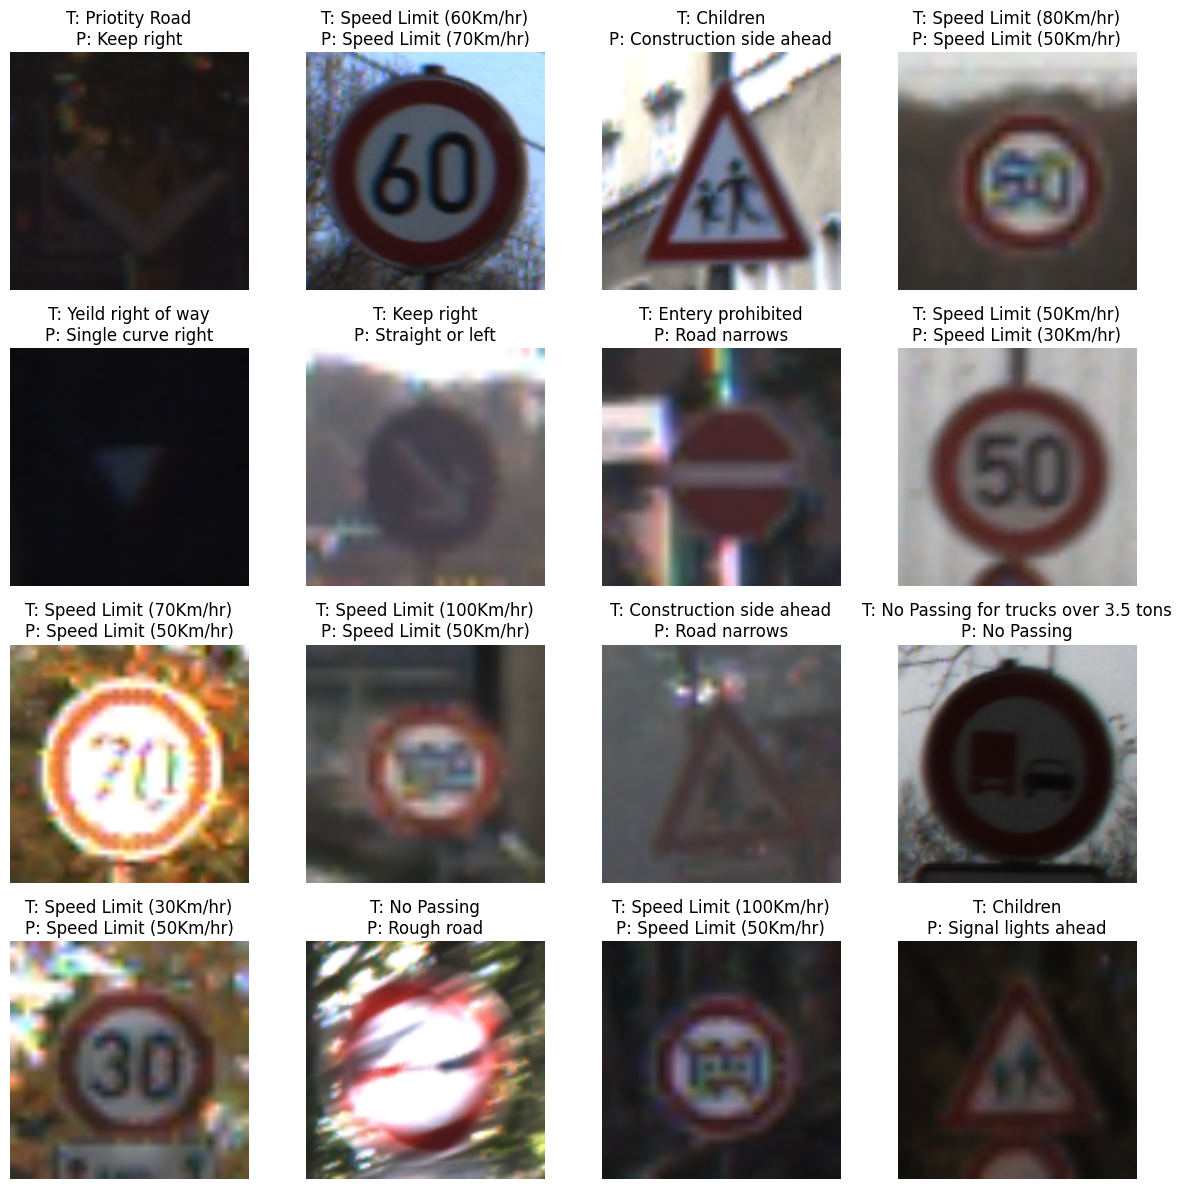

In [41]:
import matplotlib.pyplot as plt

def show_misclassified(model, loader, device, class_names, max_images=16):
    model.eval()
    images_list, true_list, pred_list = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = outputs.max(1)

            mismatch = preds != labels
            if mismatch.any():
                for img, t, p, m in zip(images, labels, preds, mismatch):
                    if m:
                        images_list.append(img.cpu())
                        true_list.append(t.item())
                        pred_list.append(p.item())
                    if len(images_list) >= max_images:
                        break
            if len(images_list) >= max_images:
                break

    
    n = len(images_list)
    cols = 4
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(3*cols, 3*rows))

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i in range(n):
        img = images_list[i]        
        img = img * std + mean       
        img = img.permute(1, 2, 0)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T: {class_names[true_list[i]]}\nP: {class_names[pred_list[i]]}")
    plt.tight_layout()
    plt.show()

# lets test it
show_misclassified(model_resnet18, val_loader, device, class_names)

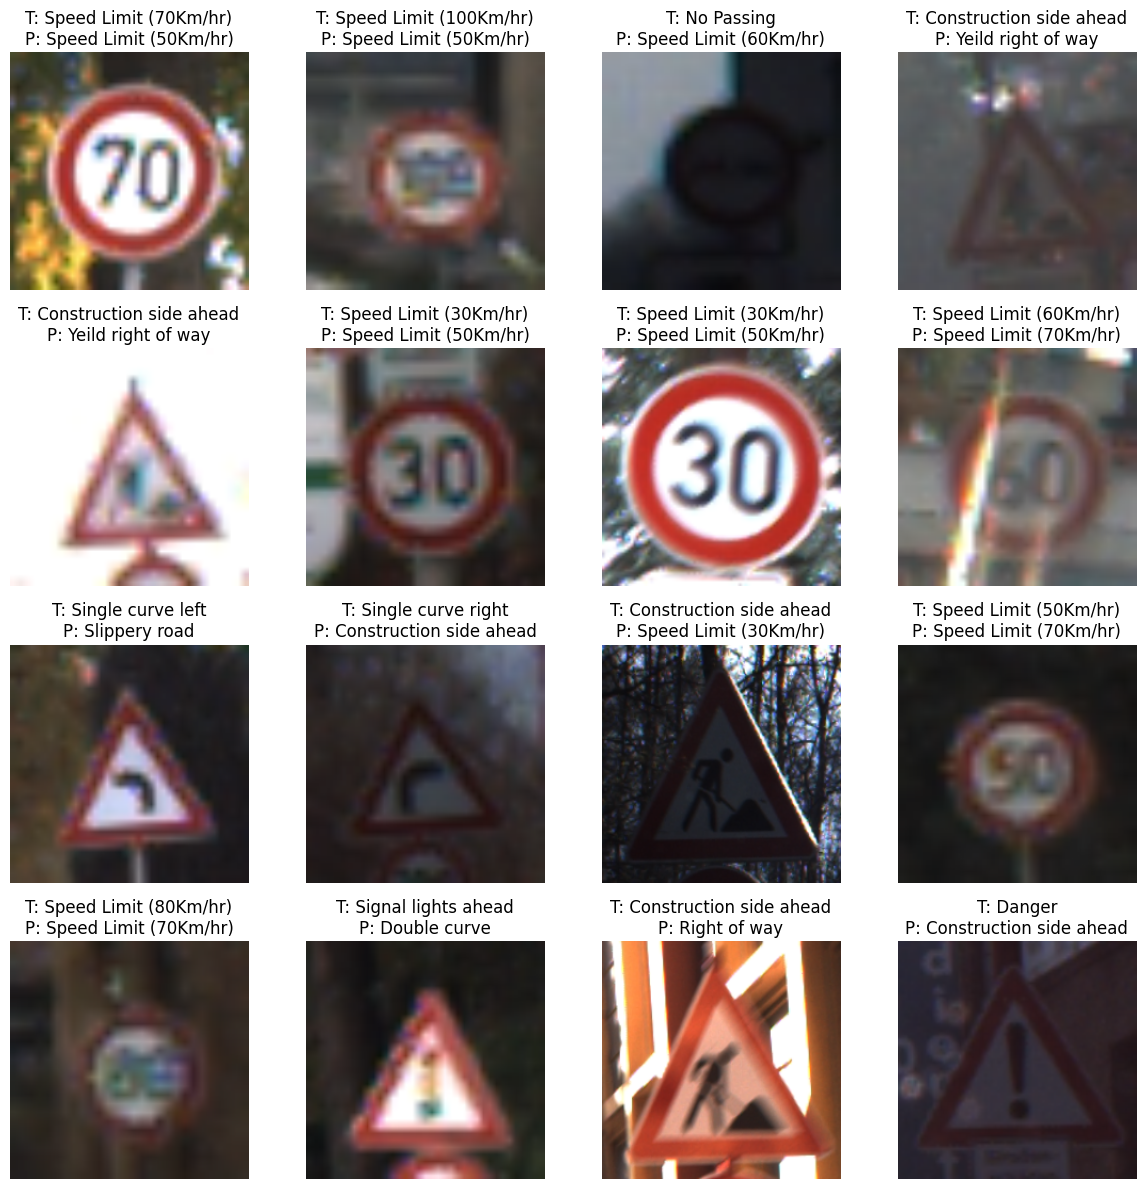

In [42]:
show_misclassified(model, val_loader, device, class_names)

Took commands from Neva and Gracie's and attempted to configure them for both models. All of this evaluation so far has been on the validation set and has allowed us to gain a good perspective on how these models should perform on the full dataset. We now test the models on the unseen data. See eval file.